In [82]:
import pandas as pd
pd.set_option('display.max_columns', 500)
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import sys
import routine
from matplotlib.offsetbox import AnchoredText
sys.path.append('../astro_tools')
sys.path.append('../')
import axes_offset

# set up the plot
plt.rcParams['text.usetex'] = False
plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.5
plt.rcParams["axes.labelweight"] = 'bold'
plt.rcParams["axes.titleweight"] = 'bold'
plt.rcParams["font.family"] = "courier new"
plt.rcParams["font.style"] = "normal"
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.weight"] = 'bold'

Afont = {
        'family' : 'courier new',
        'color':  'black',
        'size': 25,
        }


In [4]:
def gaussian(x_array, amp, cen, sigma):

    """
    Function to create a Gaussian.

    Parameters
    -------------------

    x_array : array
        Array of x values.

    amp : int or float
        Amplitude of the Gaussian.

    cen : int or float
        Center of the Gaussian.

    sigma : int or float
        Width of the Gaussian.

    """

    return(amp*(np.exp((-1.0/2.0)*(((x_array-cen)/sigma)**2))))


def wavelength_to_velocity(wls, Vsys, restwl):

    """
    This function converts wavelengths to velocity in km/s.
    """

    c = 3.0*10**5

    vels = (wls*c / restwl) - c

    return vels - Vsys


def plot_fits(ax, x, y, cube, which_model, xlab, ylab, region='se'):
    
    spec_axis = np.array(cube.spectral_axis)  # grab the spectral axis
    spectrum = np.array(cube[:,y,x], dtype='float64')  # grab the y-values
    model_num = which_model[0].data[y,x]  # get the model we use
    
    if region == 'se':
        fits1 = pd.read_csv('../ngc253/muse/Nov28/fits1_total/fits1_reordered.txt')
        fits2 = pd.read_csv('../ngc253/muse/Nov28/fits2_total/fits2_reordered.txt')
        fits3 = pd.read_csv('../ngc253/muse/Nov28/fits3_total/fits3_reordered.txt')
    else:
        fits1 = pd.read_csv('../ngc253/muse/NW/Jan22/fits1_total/fits1_reordered.txt')
        fits2 = pd.read_csv('../ngc253/muse/NW/Jan22/fits2_total/fits2_reordered.txt')
        fits3 = pd.read_csv('../ngc253/muse/NW/Jan22/fits3_total/fits3_reordered.txt')

    # grab the data
    if model_num == 1.0:
        fits1 = fits1[(fits1['X'] == x) & (fits1['Y'] == y)]
        amps_list = [fits1['Amp%s' % i].values[0] for i in range(1,6,1)]
        wvls_list = [fits1['Wvl%s' % i].values[0] for i in range(1,6,1)]
        vels_list = [fits1['Vel%s' % i].values[0] for i in range(1,6,1)]
        sigs_list = [fits1['Sig%s' % i].values[0] for i in range(1,6,1)]
    elif model_num == 2.0:
        fits2 = fits2[(fits2['X'] == x) & (fits2['Y'] == y)]
        amps_list = [fits2['Amp%s' % i].values[0] for i in range(1,11,1)]
        wvls_list = [fits2['Wvl%s' % i].values[0] for i in range(1,11,1)]
        vels_list = [fits2['Vel%s' % i].values[0] for i in range(1,11,1)]
        sigs_list = [fits2['Sig%s' % i].values[0] for i in range(1,11,1)]
    elif model_num == 3.0:
        fits3 = fits3[(fits3['X'] == x) & (fits3['Y'] == y)]
        amps_list = [fits3['Amp%s' % i].values[0] for i in range(1,16,1)]
        wvls_list = [fits3['Wvl%s' % i].values[0] for i in range(1,16,1)]
        vels_list = [fits3['Vel%s' % i].values[0] for i in range(1,16,1)]
        sigs_list = [fits3['Sig%s' % i].values[0] for i in range(1,16,1)]
        
    # get the components and sum (model)
    components = [gaussian(spec_axis, amps_list[i], wvls_list[i], sigs_list[i]) 
                  for i in np.arange(len(amps_list))]
    model = sum(components)
    
    # plot the big axis
    comp_offset = 0.1*np.max(spectrum)
    resid_offset = 0.2*np.max(spectrum)
    ax.step(spec_axis, spectrum, color='gray', lw=2, alpha=0.6)  # data
    ax.plot(spec_axis, model, color='tab:pink', lw=1, ls='-')  # sum
    ax.tick_params(axis='both', which='both',direction='in', 
                    width=1.5, labelsize=16, length=5, color='black')
    ax.get_xaxis().set_ticklabels([])
    
    if ylab == True:
        ax.set_ylabel('S$_{\lambda}$ ($10^{-20}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', 
               fontsize=18)
        
    # plot the residuals for the big guy
    resid = spectrum-model
    resid_ax = ax.inset_axes([0, -0.3, 1, 0.3])
    resid_ax.step(spec_axis, resid, 
              color='tab:purple', lw=1.5, ls='-') # resid
    resid_ax.plot(spec_axis, [0]*len(spec_axis), 
              color='black', lw=1, alpha=0.6, ls='--')
    resid_ax.set_xlim(np.min(spec_axis), 6700)
    resid_ax.tick_params(axis='both', which='both',direction='in', 
                    width=1.5, labelsize=16, length=5, color='black')
    resid_ax.set_ylim(bottom=-np.max(resid[(spec_axis > 6700)])\
                  -np.max(spectrum[(spec_axis > 6700)])*0.1,
                      top=np.max(resid[(spec_axis > 6700)])\
                  +np.max(spectrum[(spec_axis > 6700)])*0.1)

    if ylab == True:
        resid_ax.set_ylabel('Residuals', fontsize=16)
    if xlab == True:
        resid_ax.set_xlabel('Wavelength ($\AA$)', fontsize=18)
        
    # set up plotting the components for both axes
    ax.plot(spec_axis, [-comp_offset]*len(spec_axis), color='tab:cyan', lw=1, ls='--')
    axin = ax.inset_axes([0.55, 0.5, 0.43, 0.43])
    axin.plot(spec_axis, [-comp_offset]*len(spec_axis), color='tab:cyan', lw=1, ls='--')
    
    i = 0
    while i < len(components):
        y_vals = components[i]
        y_vals[y_vals <= 0.001] = np.nan
        ax.plot(spec_axis, y_vals-comp_offset, color='tab:cyan', lw=1, ls='--')
        axin.plot(spec_axis, y_vals-comp_offset, color='tab:cyan', lw=1, ls='--')
        i+=1
        
    # set the x-limit of the bigger axis
    ax.set_xlim(np.min(spec_axis), 6700)
        
    # plot inset axis data
    axin.step(spec_axis, spectrum, color='gray', lw=2, alpha=0.6)  # data
    axin.plot(spec_axis, model, color='tab:pink', lw=1, ls='-')  # sum
    axin.set_xlim(6700, 6750)
    axin.set_xticks([6710, 6720, 6730, 6740])
    axin.tick_params(axis='both', which='both',direction='in', 
                    width=1.5, labelsize=10, length=5, color='black')
    axin.set_ylim(top=np.max(spectrum[(spec_axis > 6700)])\
                  +np.max(spectrum[(spec_axis > 6700)])*0.1)
    
    # plot the residuals for the inset axis data
    resid = spectrum-model
    resid_axin = ax.inset_axes([0.55, 0.4, 0.43, 0.1])
    resid_axin.step(spec_axis, resid, 
              color='tab:purple', lw=1.5, ls='-') # resid
    resid_axin.plot(spec_axis, [0]*len(spec_axis), 
              color='black', lw=1, alpha=0.6, ls='--')
    resid_axin.set_xlim(6700,6750)
    resid_axin.set_ylim(bottom = -np.max(resid[(spec_axis > 6700)])\
                        -np.max(resid[(spec_axis > 6700)])*0.3,
                        top=np.max(resid[(spec_axis > 6700)])\
                  +np.max(resid[(spec_axis > 6700)])*0.3)
    resid_axin.tick_params(axis='both', which='both',direction='in', 
                    width=1.5, labelsize=10, length=5, color='black')
    resid_axin.set_xticks([6710, 6710, 6720, 6730, 6740])
    
    # make lighter linewidth for inset axis
    for axis in ['top','bottom','left','right']:
        axin.spines[axis].set_linewidth(1.5)
        resid_axin.spines[axis].set_linewidth(1.5)
        
    ax.set_title('(x,y) = %s,%s' % (x,y), fontsize=20)
    
    if cube.shape == (241, 436, 437):
        region = 'SE'
    else:
        region = 'NW'
        
    at = AnchoredText(region, prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    if model_num == 1:
        comp_text = '%s component'
    else:
        comp_text = '%s components'
        
    ax.text(0.04, 0.75, comp_text % int(model_num), fontsize=18, 
            transform=ax.transAxes)

    return



In [638]:
which_model = fits.open('../ngc253/muse/Nov28/BIC_PHYS_RATIO_1p25.fits')
which_model_nw = fits.open('../ngc253/muse/NW/Jan22/BIC_PHYS_RATIO_1p25.fits')
print(which_model[0].data.shape)
fits1 = pd.read_csv('../ngc253/muse/Nov28/fits1_total/fits1_reordered.txt')
fits2 = pd.read_csv('../ngc253/muse/Nov28/fits2_total/fits2_reordered.txt')
fits3 = pd.read_csv('../ngc253/muse/Nov28/fits3_total/fits3_reordered.txt')


(436, 437)


In [641]:
fits2[(fits2['X'] == 125) & (fits2['Y'] == 106)]

,X,Y,RedChiSq,Amp1,Amp2,Amp3,Amp4,Amp5,Amp6,Amp7,Amp8,Amp9,Amp10,Wvl1,Wvl2,Wvl3,Wvl4,Wvl5,Wvl6,Wvl7,Wvl8,Wvl9,Wvl10,Sig1,Sig2,Sig3,Sig4,Sig5,Sig6,Sig7,Sig8,Sig9,Sig10,Vel1,Vel2,Vel3,Vel4,Vel5,Vel6,Vel7,Vel8,Vel9,Vel10,SigVel1,SigVel2,SigVel3,SigVel4,SigVel5,SigVel6,SigVel7,SigVel8,SigVel9,SigVel10,rms,BIC
15422,125,106,1.083,68.79,24.299,513.829,0.0,206.37,72.898,91.947,22.805,67.269,9.751,6553.539,6557.928,6568.302,6572.702,6588.968,6593.382,6722.07,6726.572,6736.462,6740.974,1.24,1.467,1.24,1.467,1.24,1.467,1.24,1.467,1.24,1.467,8.668884,214.243958,8.651815,214.278892,8.637458,214.271801,8.661787,214.2429,8.65933,214.256899,56.810806,67.210849,56.683114,67.059781,56.505328,66.849448,55.386485,65.525784,55.268155,65.385793,10.54043,209.581624


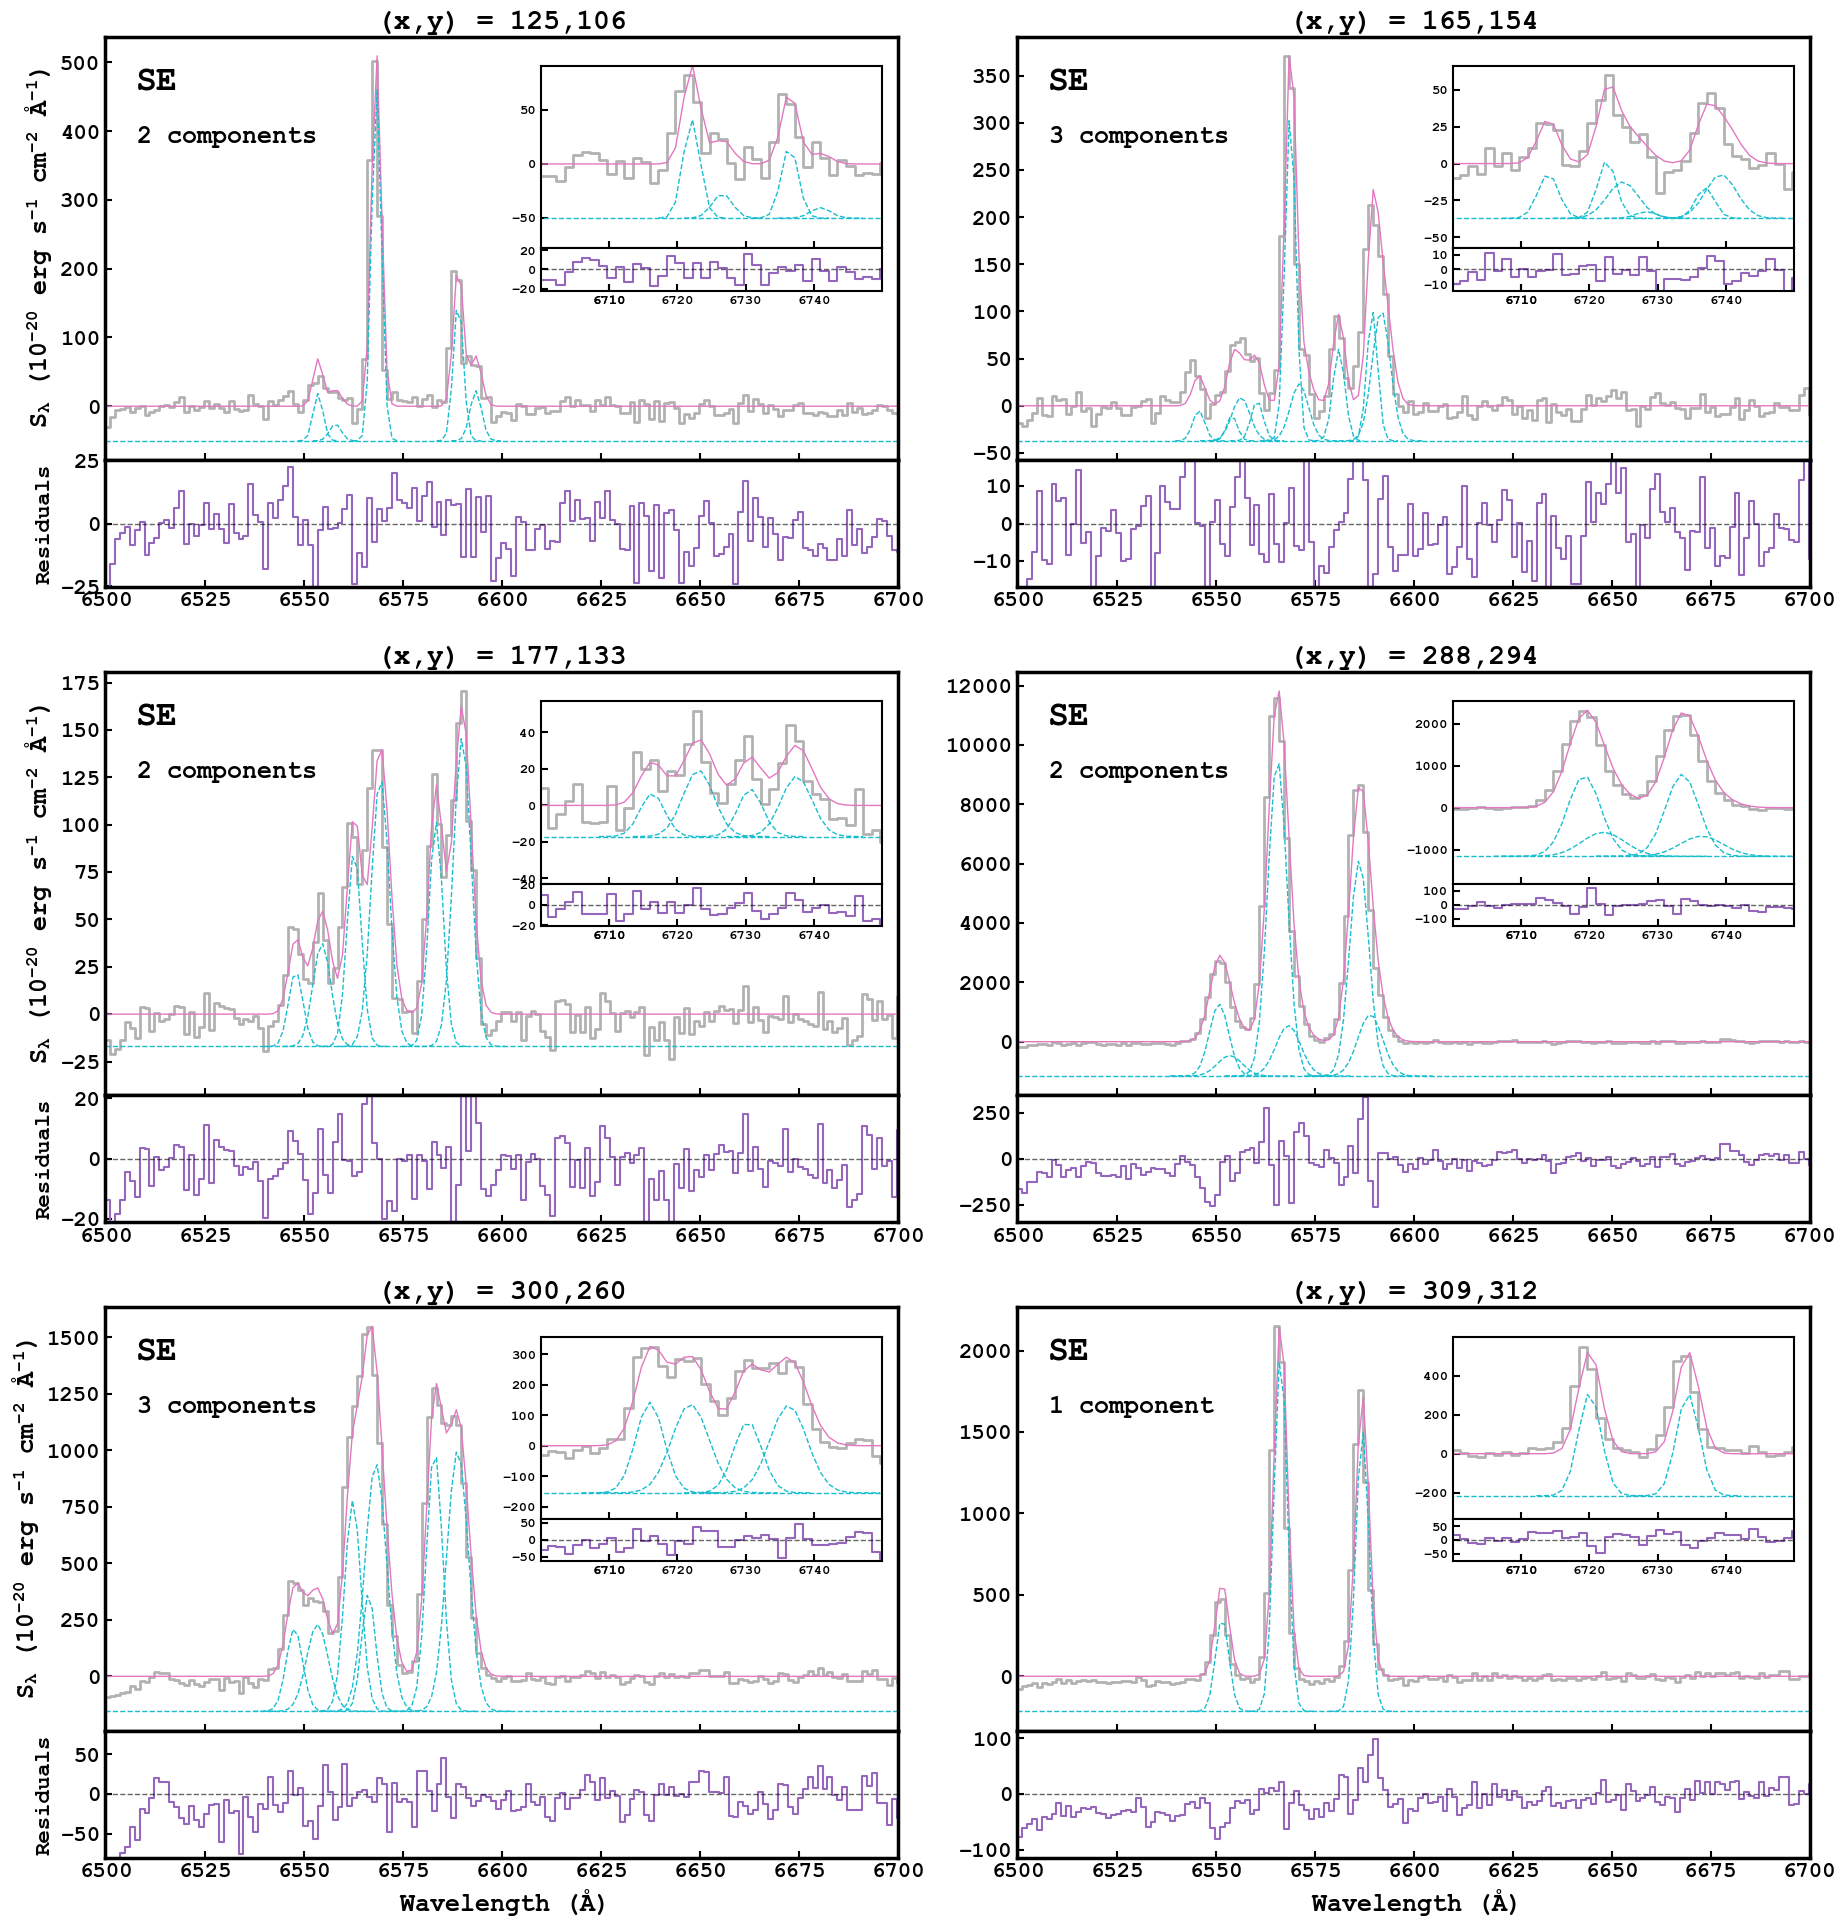

In [642]:
se_file = '../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
se = routine.CreateCube(se_file, SlabLower=6500, SlabUpper=6800, 
                  ContLower1=6525, ContUpper1=6620, ContLower2=6700, ContUpper2=6750)

# set up the figure
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(22, 22))

plot_fits(ax=ax1, x=125,y=106, cube=se, which_model=which_model, xlab=False, ylab=True)
plot_fits(ax=ax2, x=165,y=154, cube=se, which_model=which_model, xlab=False, ylab=False)
plot_fits(ax=ax3, x=177,y=133, cube=se, which_model=which_model, xlab=False, ylab=True)
plot_fits(ax=ax4, x=288,y=294, cube=se, which_model=which_model, xlab=False, ylab=False)
plot_fits(ax=ax5, x=300,y=260, cube=se, which_model=which_model, xlab=True, ylab=True)
plot_fits(ax=ax6, x=309,y=312, cube=se, which_model=which_model, xlab=True, ylab=False)
plt.subplots_adjust(wspace=0.15, hspace=0.5)
plt.savefig('../ngc253/muse/visuals/se_fits.png',bbox_inches='tight', dpi=200)
plt.savefig('../ngc253/muse/visuals/se_fits.pdf',bbox_inches='tight', dpi=200)


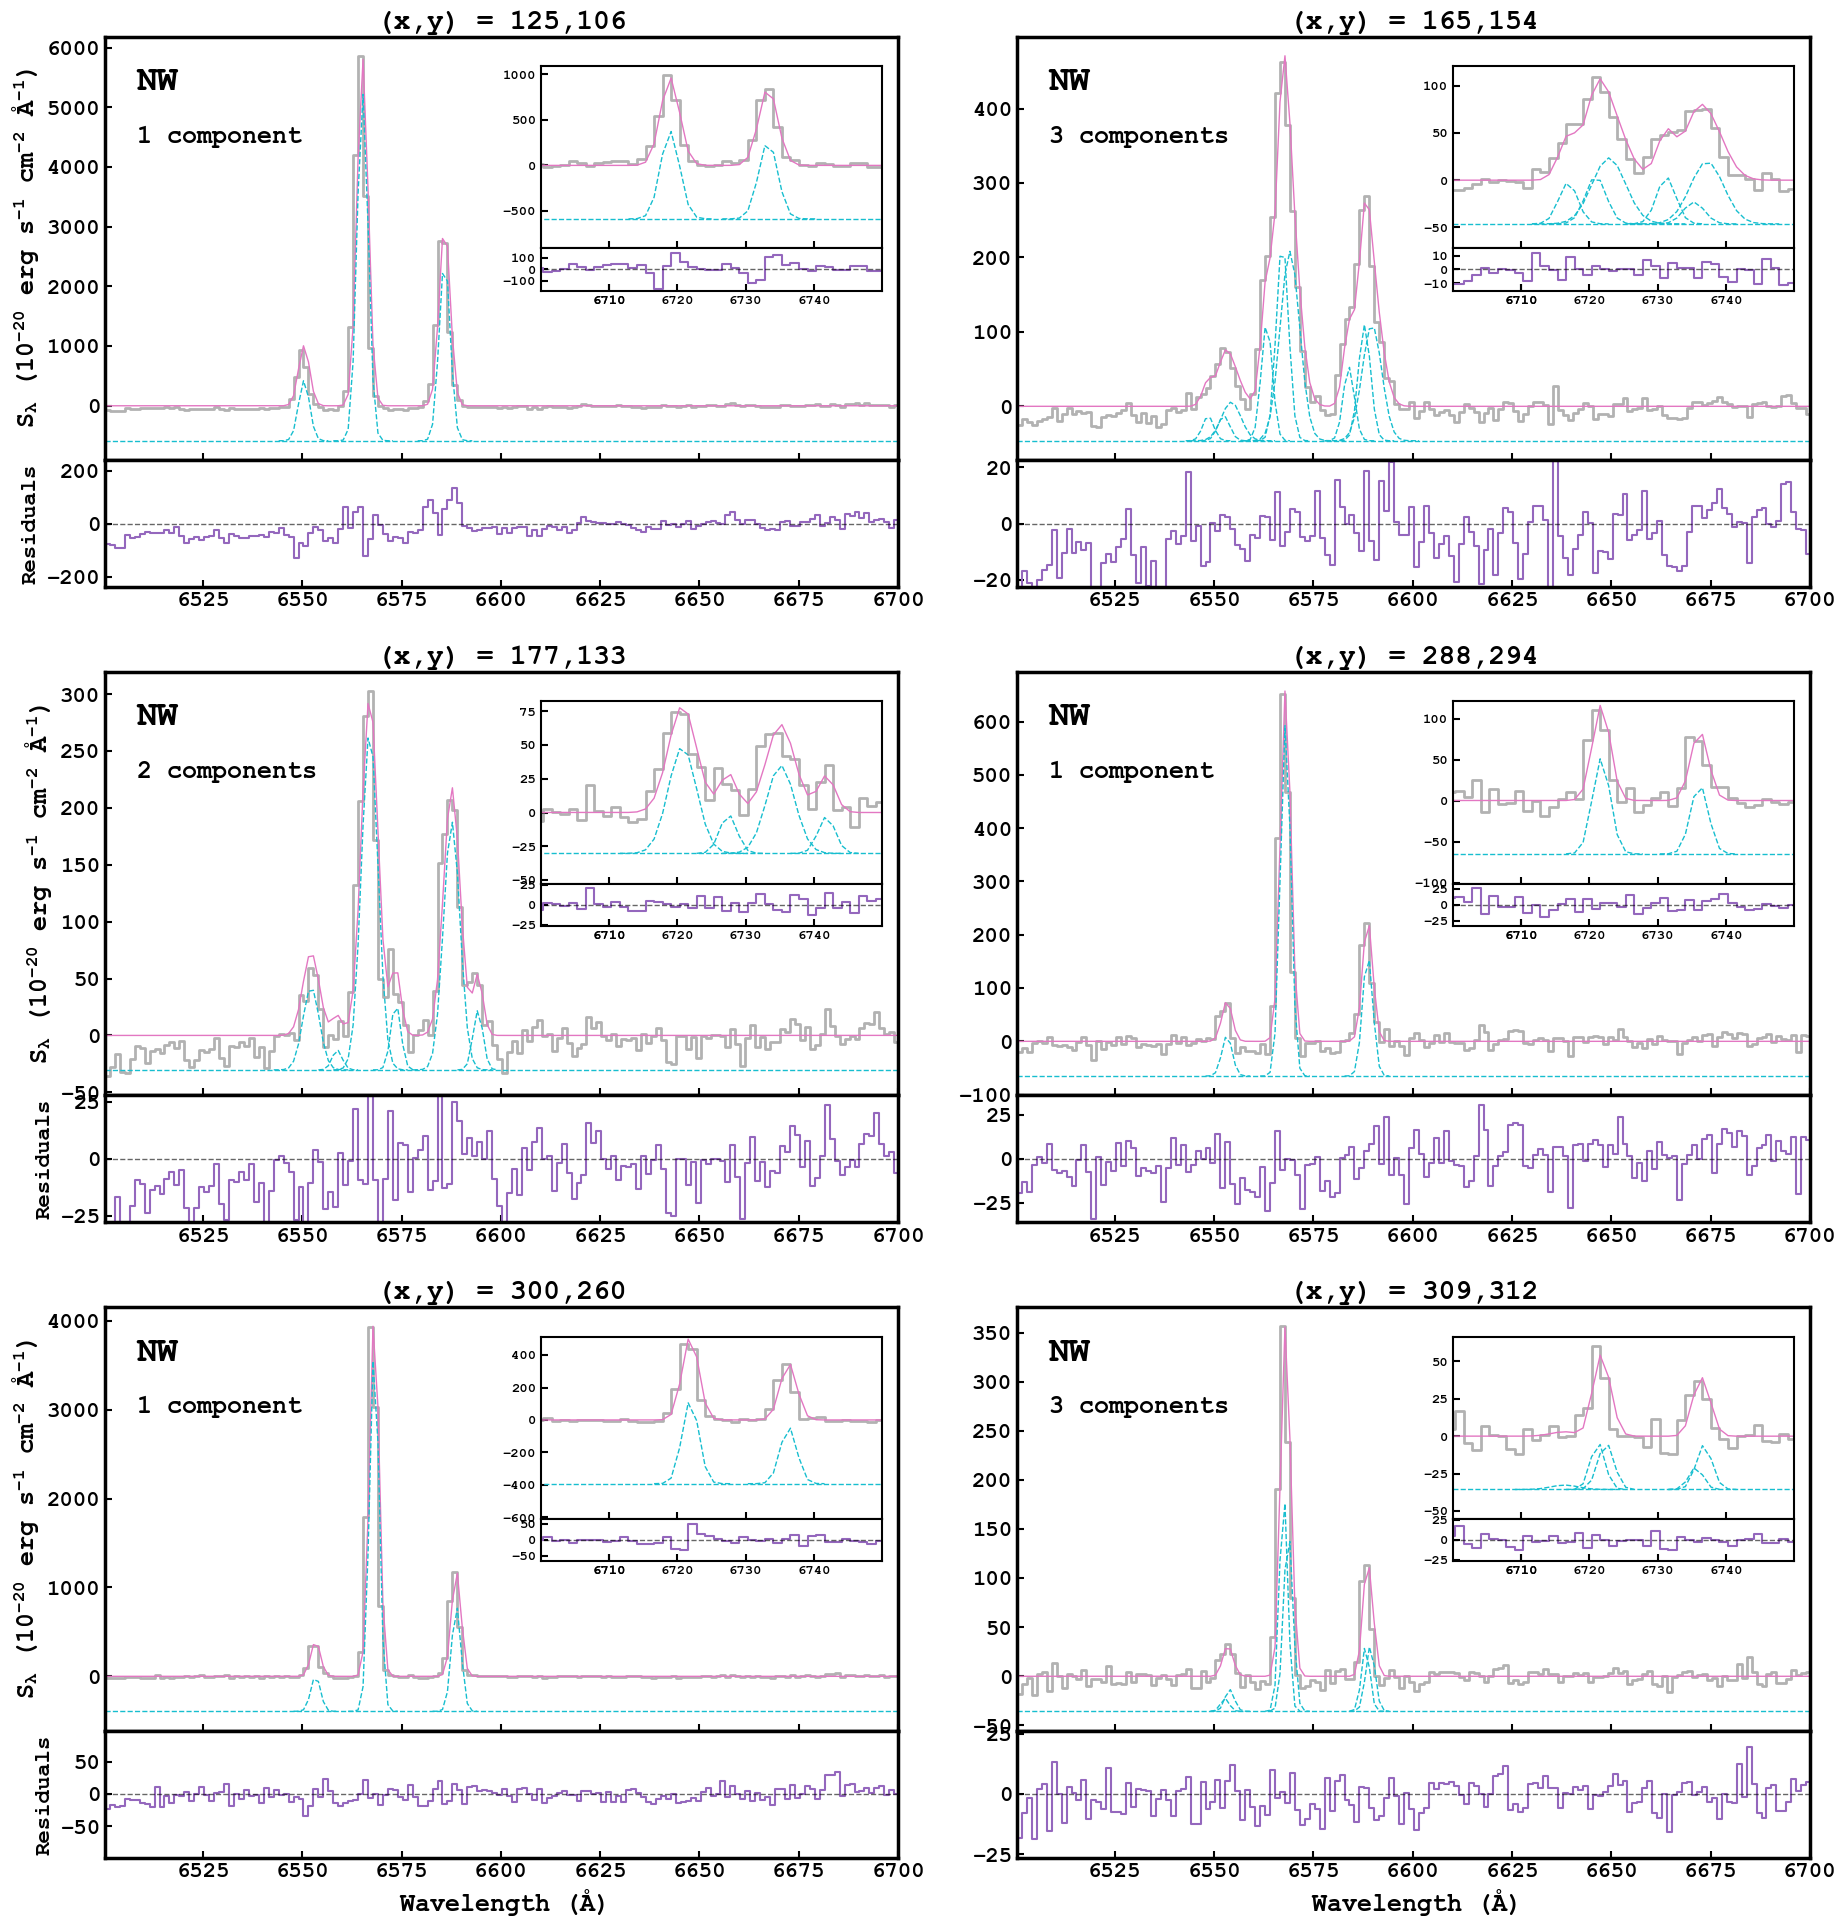

In [643]:
nw_file = '../ngc253/muse/data/ADP.2019-08-24T09_53_08.548.fits'
nw = routine.CreateCube(nw_file, SlabLower=6500, SlabUpper=6800, 
                  ContLower1=6525, ContUpper1=6620, ContLower2=6700, ContUpper2=6750)

# set up the figure
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(22, 22))

plot_fits(ax=ax1, x=125,y=106, cube=nw, which_model=which_model_nw, 
          xlab=False, ylab=True, region='nw')
plot_fits(ax=ax2, x=165,y=154, cube=nw, which_model=which_model_nw, 
          xlab=False, ylab=False, region='nw')
plot_fits(ax=ax3, x=177,y=133, cube=nw, which_model=which_model_nw, 
          xlab=False, ylab=True, region='nw')
plot_fits(ax=ax4, x=288,y=294, cube=nw, which_model=which_model_nw, 
          xlab=False, ylab=False, region='nw')
plot_fits(ax=ax5, x=300,y=260, cube=nw, which_model=which_model_nw, 
          xlab=True, ylab=True, region='nw')
plot_fits(ax=ax6, x=309,y=312, cube=nw, which_model=which_model_nw, 
          xlab=True, ylab=False, region='nw')
plt.subplots_adjust(wspace=0.15, hspace=0.5)
plt.savefig('../ngc253/muse/visuals/nw_fits.png',bbox_inches='tight', dpi=200)
plt.savefig('../ngc253/muse/visuals/nw_fits.pdf',bbox_inches='tight', dpi=200)


### Same as above, but chosing to color each system of lines

In [97]:
def plot_fits_alt(dat, ax, x, y, cube, which_model, xlab, ylab, region='se'):
    
    spec_axis = np.array(cube.spectral_axis)  # grab the spectral axis
    spectrum = np.array(cube[:,y,x], dtype='float64')  # grab the y-values
    model_num = which_model[0].data[y,x]  # get the model we use
    
    if region == 'se':
        fits1 = pd.read_csv('../ngc253/muse/Nov28/fits1_total/fits1_reordered.txt')
        fits2 = pd.read_csv('../ngc253/muse/Nov28/fits2_total/fits2_reordered.txt')
        fits3 = pd.read_csv('../ngc253/muse/Nov28/fits3_total/fits3_reordered.txt')
    else:
        fits1 = pd.read_csv('../ngc253/muse/NW/Jan22/fits1_total/fits1_reordered.txt')
        fits2 = pd.read_csv('../ngc253/muse/NW/Jan22/fits2_total/fits2_reordered.txt')
        fits3 = pd.read_csv('../ngc253/muse/NW/Jan22/fits3_total/fits3_reordered.txt')

    # grab the data
    if model_num == 1.0:
        fits1 = fits1[(fits1['X'] == x) & (fits1['Y'] == y)]
        amps_list = [fits1['Amp%s' % i].values[0] for i in range(1,6,1)]
        wvls_list = [fits1['Wvl%s' % i].values[0] for i in range(1,6,1)]
        vels_list = [fits1['Vel%s' % i].values[0] for i in range(1,6,1)]
        sigs_list = [fits1['Sig%s' % i].values[0] for i in range(1,6,1)]
    elif model_num == 2.0:
        fits2 = fits2[(fits2['X'] == x) & (fits2['Y'] == y)]
        amps_list = [fits2['Amp%s' % i].values[0] for i in range(1,11,1)]
        wvls_list = [fits2['Wvl%s' % i].values[0] for i in range(1,11,1)]
        vels_list = [fits2['Vel%s' % i].values[0] for i in range(1,11,1)]
        sigs_list = [fits2['Sig%s' % i].values[0] for i in range(1,11,1)]
    elif model_num == 3.0:
        fits3 = fits3[(fits3['X'] == x) & (fits3['Y'] == y)]
        amps_list = [fits3['Amp%s' % i].values[0] for i in range(1,16,1)]
        wvls_list = [fits3['Wvl%s' % i].values[0] for i in range(1,16,1)]
        vels_list = [fits3['Vel%s' % i].values[0] for i in range(1,16,1)]
        sigs_list = [fits3['Sig%s' % i].values[0] for i in range(1,16,1)]
        
    # get the components and sum (model)
    components = [gaussian(spec_axis, amps_list[i], wvls_list[i], sigs_list[i]) 
                  for i in np.arange(len(amps_list))]
    model = sum(components)
    
    # plot the big axis
    comp_offset = 0.1*np.max(spectrum)
    resid_offset = 0.2*np.max(spectrum)
    ax.step(spec_axis, spectrum, color='gray', lw=2, alpha=0.6)  # data
    ax.plot(spec_axis, model, color='black', lw=1, ls='-')  # sum
    ax.tick_params(axis='both', which='both',direction='in', 
                    width=1.5, labelsize=16, length=5, color='black')
    ax.get_xaxis().set_ticklabels([])
    
    if ylab == True:
        ax.set_ylabel('S$_{\lambda}$ ($10^{-20}$ erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$)', 
               fontsize=18)
        
    # plot the residuals for the big guy
    resid = spectrum-model
    resid_ax = ax.inset_axes([0, -0.3, 1, 0.3])
    resid_ax.step(spec_axis, resid, 
              color='gray', lw=1.5, ls='-') # resid
    resid_ax.plot(spec_axis, [0]*len(spec_axis), 
              color='black', lw=1, alpha=0.6, ls='--')
    resid_ax.set_xlim(np.min(spec_axis), 6700)
    resid_ax.tick_params(axis='both', which='both',direction='in', 
                    width=1.5, labelsize=16, length=5, color='black')
    resid_ax.set_ylim(bottom=-np.max(resid[(spec_axis > 6700)])\
                  -np.max(spectrum[(spec_axis > 6700)])*0.1,
                      top=np.max(resid[(spec_axis > 6700)])\
                  +np.max(spectrum[(spec_axis > 6700)])*0.1)

    if ylab == True:
        resid_ax.set_ylabel('Residuals', fontsize=16)
    if xlab == True:
        resid_ax.set_xlabel('Wavelength ($\AA$)', fontsize=18)
        
    # set up plotting the components for both axes
    ax.plot(spec_axis, [-comp_offset]*len(spec_axis), color='gray', alpha=0.6,lw=1, ls='--')
    axin = ax.inset_axes([0.55, 0.5, 0.43, 0.43])
    axin.plot(spec_axis, [-comp_offset]*len(spec_axis), color='gray', lw=1, alpha=0.6,ls='--')
    
    if len(components) == 5:
        colors = ['#66CCEE']*5
    elif len(components) == 5*2:
        colors = ['#66CCEE','#AA3377']*5
    elif len(components) == 5*3:
        colors = ['#66CCEE','#AA3377','#CCBB44']*5
    
    i = 0
    while i < len(components):
        y_vals = components[i]
        y_vals[y_vals <= 0.001] = np.nan  # to make the Gaussian tails not stretch across entire plot
        ax.plot(spec_axis, y_vals-comp_offset, color=colors[i], lw=1, ls='--')
        axin.plot(spec_axis, y_vals-comp_offset, color=colors[i], lw=1, ls='--')
        ax.fill(spec_axis, y_vals-comp_offset, color=colors[i], alpha=0.3)    
        axin.fill(spec_axis, y_vals-comp_offset, color=colors[i], alpha=0.3)
        i+=1
        
    # set the x-limit of the bigger axis
    ax.set_xlim(np.min(spec_axis), 6700)
        
    # plot inset axis data
    axin.step(spec_axis, spectrum, color='gray', lw=2, alpha=0.6)  # data
    axin.plot(spec_axis, model, color='black', lw=1, ls='-')  # sum
    axin.set_xlim(6700, 6750)
    axin.set_xticks([6710, 6720, 6730, 6740])
    axin.tick_params(axis='both', which='both',direction='in', 
                    width=1.5, labelsize=10, length=5, color='black')
    axin.set_ylim(top=np.max(spectrum[(spec_axis > 6700)])\
                  +np.max(spectrum[(spec_axis > 6700)])*0.1)
    
    # plot the residuals for the inset axis data
    resid = spectrum-model
    resid_axin = ax.inset_axes([0.55, 0.4, 0.43, 0.1])
    resid_axin.step(spec_axis, resid, 
              color='gray', lw=1.5, ls='-') # resid
    resid_axin.plot(spec_axis, [0]*len(spec_axis), 
              color='black', lw=1, alpha=0.6, ls='--')
    resid_axin.set_xlim(6700,6750)
    resid_axin.set_ylim(bottom = -np.max(resid[(spec_axis > 6700)])\
                        -np.max(resid[(spec_axis > 6700)])*0.3,
                        top=np.max(resid[(spec_axis > 6700)])\
                  +np.max(resid[(spec_axis > 6700)])*0.3)
    resid_axin.tick_params(axis='both', which='both',direction='in', 
                    width=1.5, labelsize=10, length=5, color='black')
    resid_axin.set_xticks([6710, 6710, 6720, 6730, 6740])
    
    # make lighter linewidth for inset axis
    for axis in ['top','bottom','left','right']:
        axin.spines[axis].set_linewidth(1.5)
        resid_axin.spines[axis].set_linewidth(1.5)
        
    
    if cube.shape == (241, 436, 437):
        region = 'SE'
    else:
        region = 'NW'
        
    at = AnchoredText(region, prop=Afont, frameon=False, loc='upper left')
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(at)
    
    if model_num == 1:
        comp_text = '%s component'
    else:
        comp_text = '%s components'
        
    ax.text(0.04, 0.75, comp_text % int(model_num), fontsize=18, 
            transform=ax.transAxes)
    
    # set title
    x_offset, y_offset = axes_offset.pix_to_extent(x, y, dat, x_dim=2, y_dim=1, pixscale=0.2)
    ax.set_title('(R.A., Dec.) = %s", %s"' % (np.round(x_offset,2),np.round(y_offset,2)), fontsize=20)
    

    return


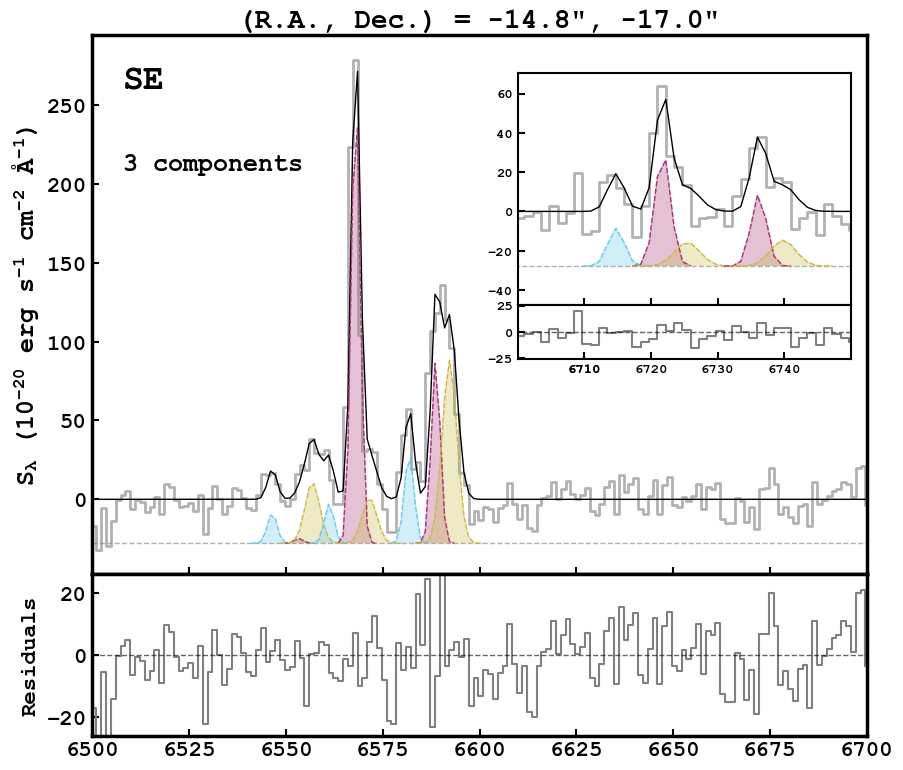

In [98]:
which_model = fits.open('../ngc253/muse/Nov28/BIC_PHYS_RATIO_1p25.fits')
se_file = '../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
se = routine.CreateCube(se_file, SlabLower=6500, SlabUpper=6800, 
                  ContLower1=6525, ContUpper1=6620, ContLower2=6700, ContUpper2=6750)
fig, (ax1) = plt.subplots(1,1, figsize=(10,7))
plot_fits_alt(dat=fits.open(se_file)[1].data, ax=ax1, x=144,y=133, cube=se, 
              which_model=which_model, xlab=False, ylab=True)

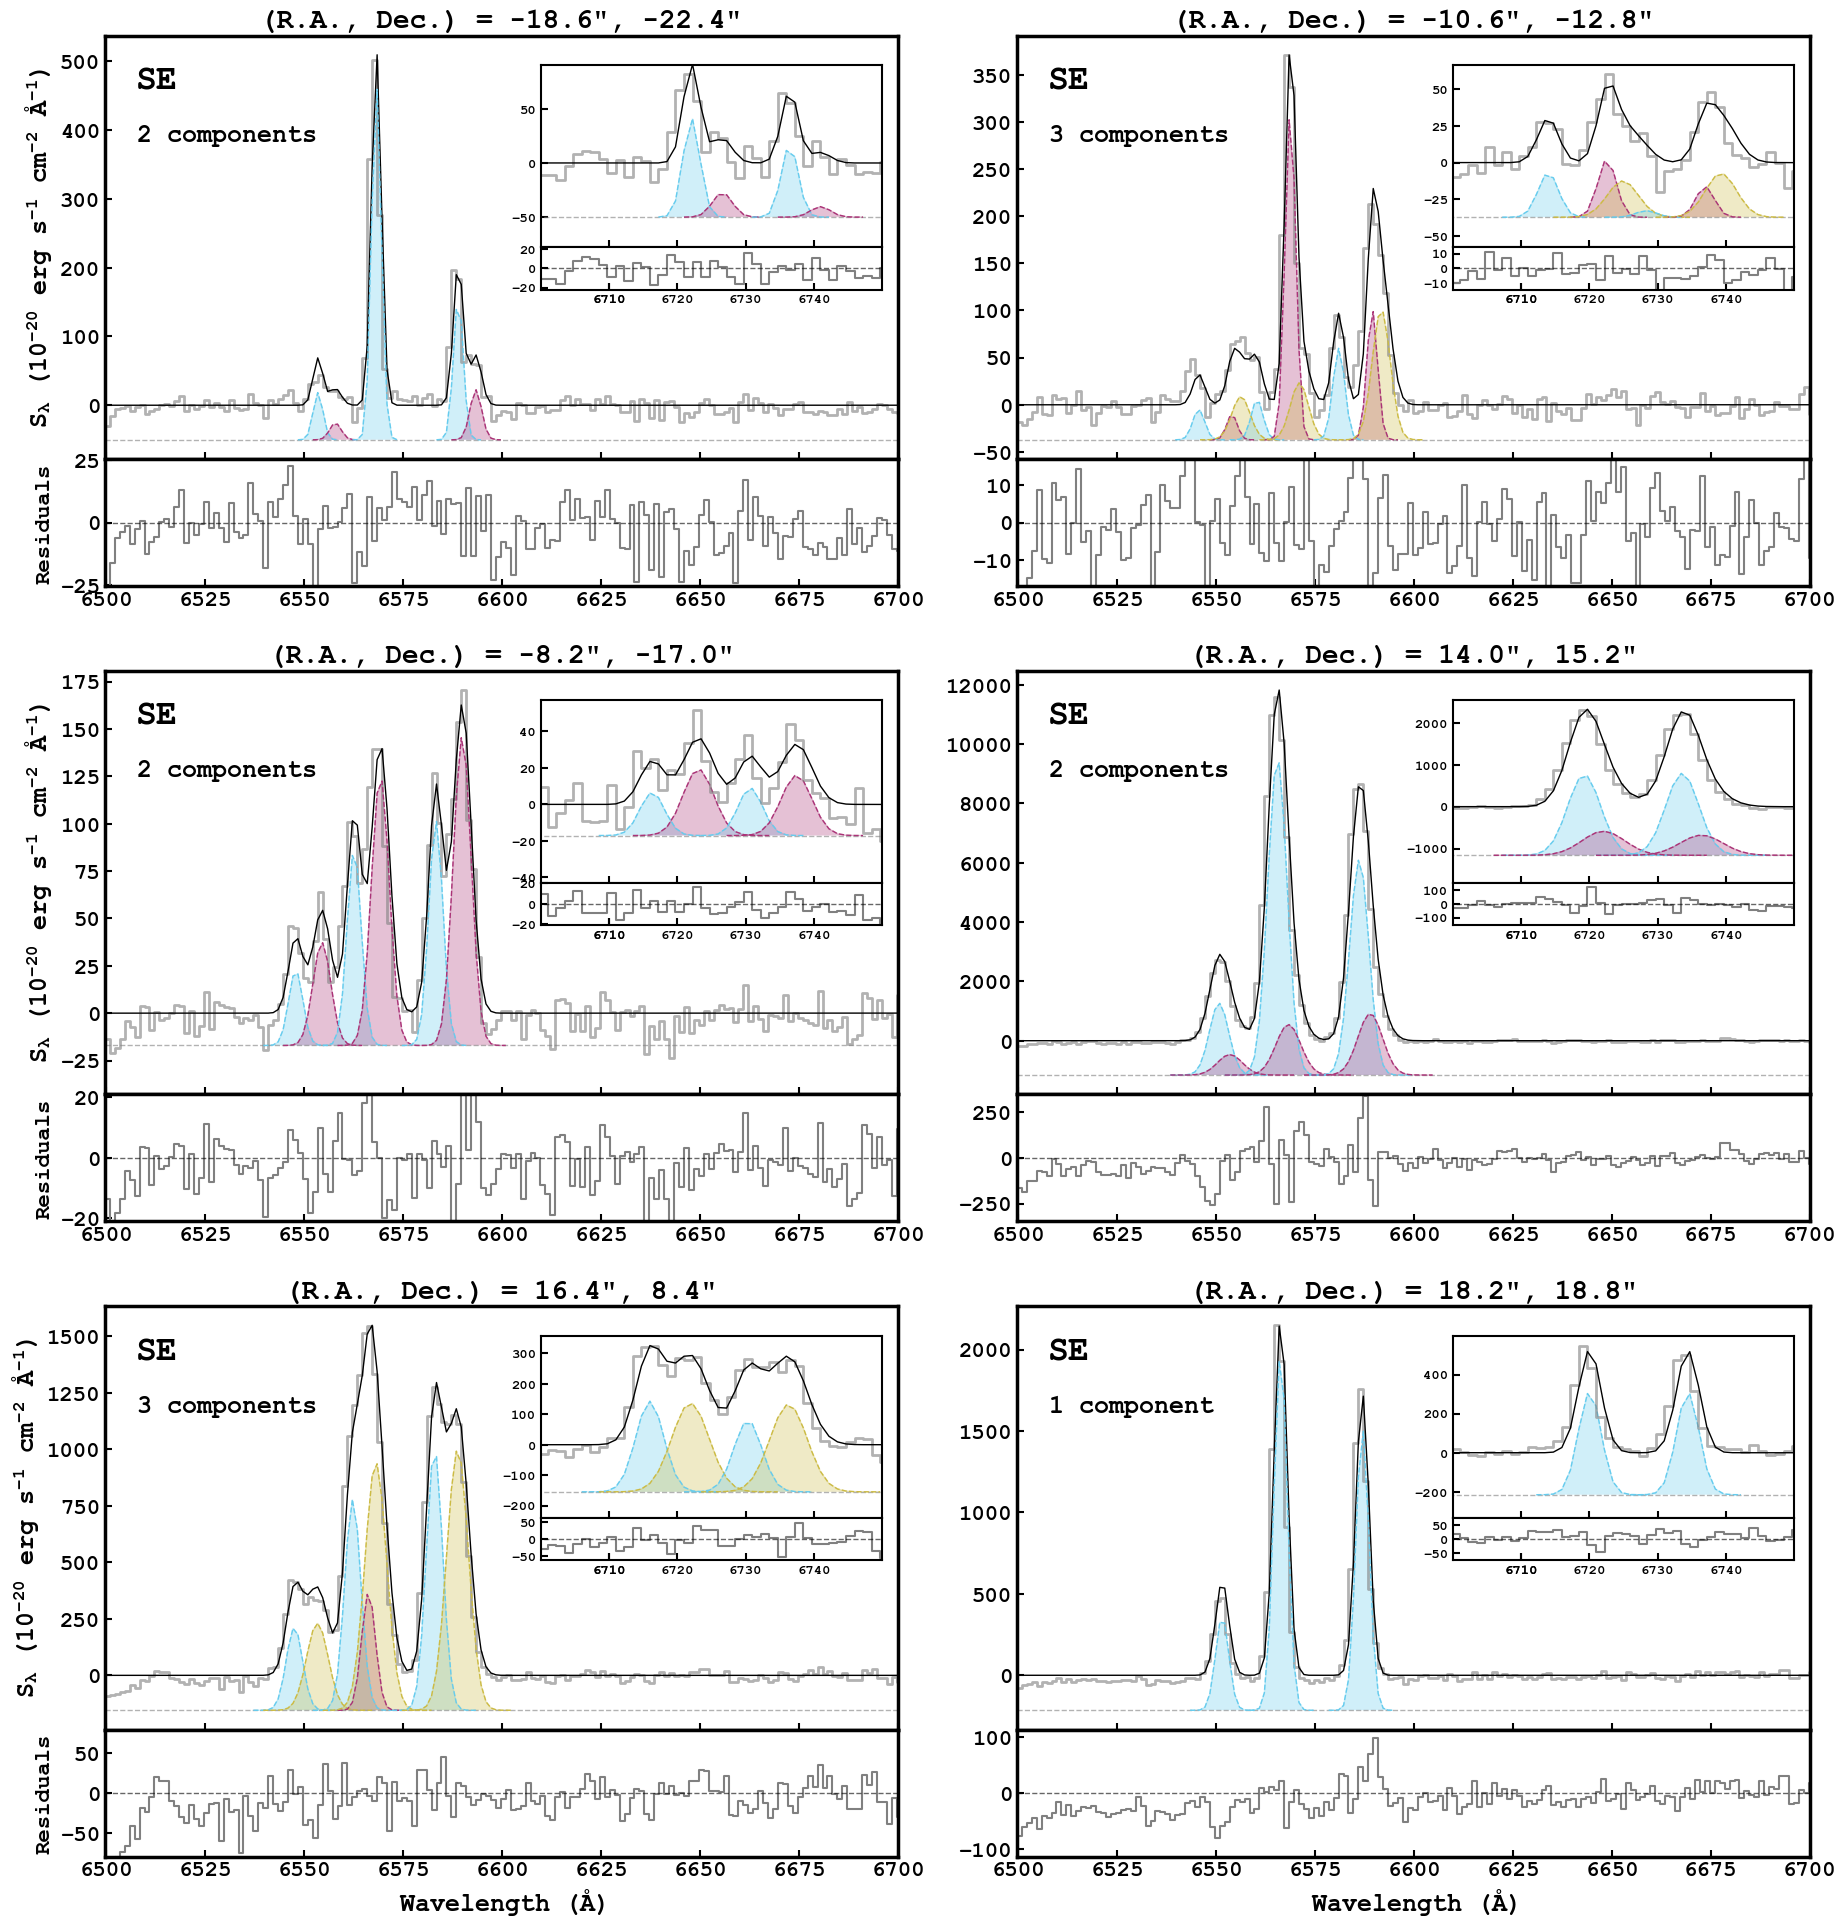

In [99]:
se_file = '../ngc253/muse/data/ADP.2018-11-22T21_29_46.157.fits'
se = routine.CreateCube(se_file, SlabLower=6500, SlabUpper=6800, 
                  ContLower1=6525, ContUpper1=6620, ContLower2=6700, ContUpper2=6750)

# set up the figure
fig, ((ax1, ax2),(ax3,ax4),(ax5,ax6)) = plt.subplots(3, 2, figsize=(22, 22))

plot_fits_alt(dat=fits.open(se_file)[1].data, ax=ax1, x=125,y=106, cube=se, 
              which_model=which_model, xlab=False, ylab=True)
plot_fits_alt(dat=fits.open(se_file)[1].data, ax=ax2, x=165,y=154, cube=se, 
              which_model=which_model, xlab=False, ylab=False)
plot_fits_alt(dat=fits.open(se_file)[1].data, ax=ax3, x=177,y=133, cube=se, 
              which_model=which_model, xlab=False, ylab=True)
plot_fits_alt(dat=fits.open(se_file)[1].data, ax=ax4, x=288,y=294, cube=se, 
              which_model=which_model, xlab=False, ylab=False)
plot_fits_alt(dat=fits.open(se_file)[1].data, ax=ax5, x=300,y=260, cube=se, 
              which_model=which_model, xlab=True, ylab=True)
plot_fits_alt(dat=fits.open(se_file)[1].data, ax=ax6, x=309,y=312, cube=se, 
              which_model=which_model, xlab=True, ylab=False)
plt.subplots_adjust(wspace=0.15, hspace=0.5)
plt.savefig('../ngc253/muse/visuals/se_fits_v2.png',bbox_inches='tight', dpi=200)
plt.savefig('../ngc253/muse/visuals/se_fits_v2.pdf',bbox_inches='tight', dpi=200)
